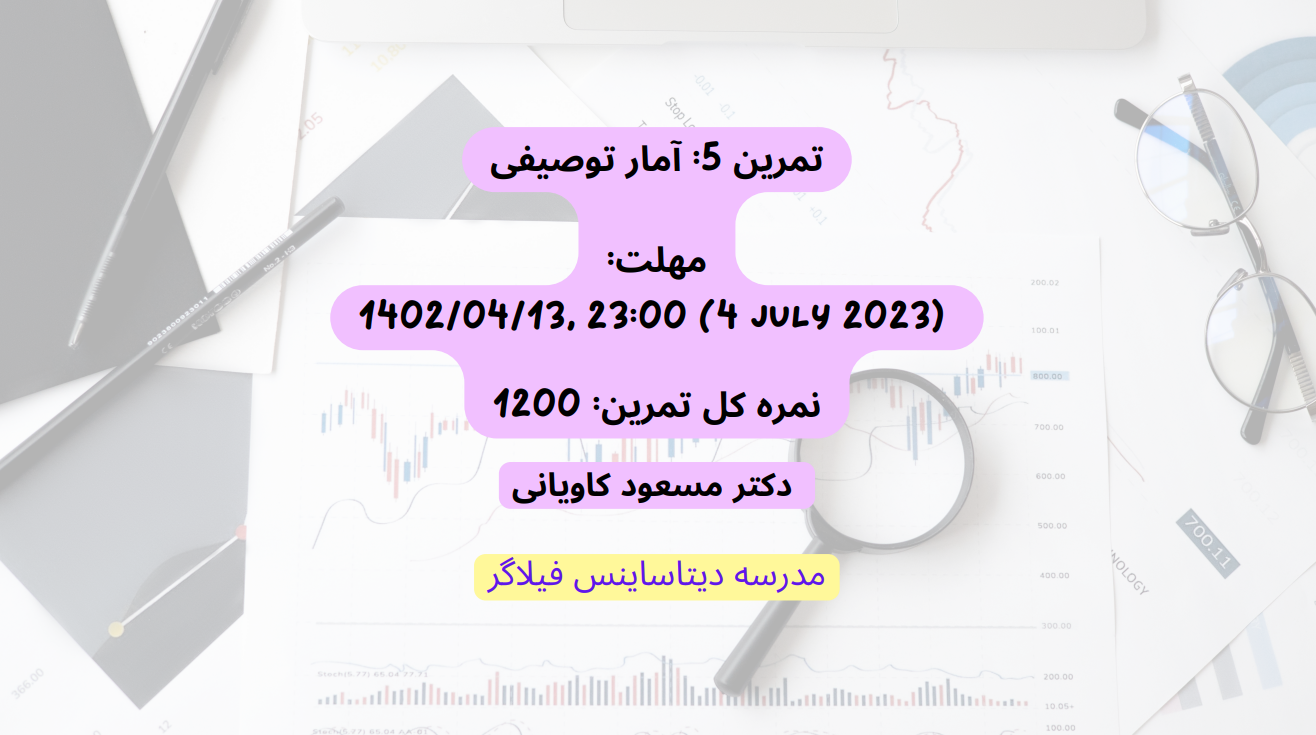
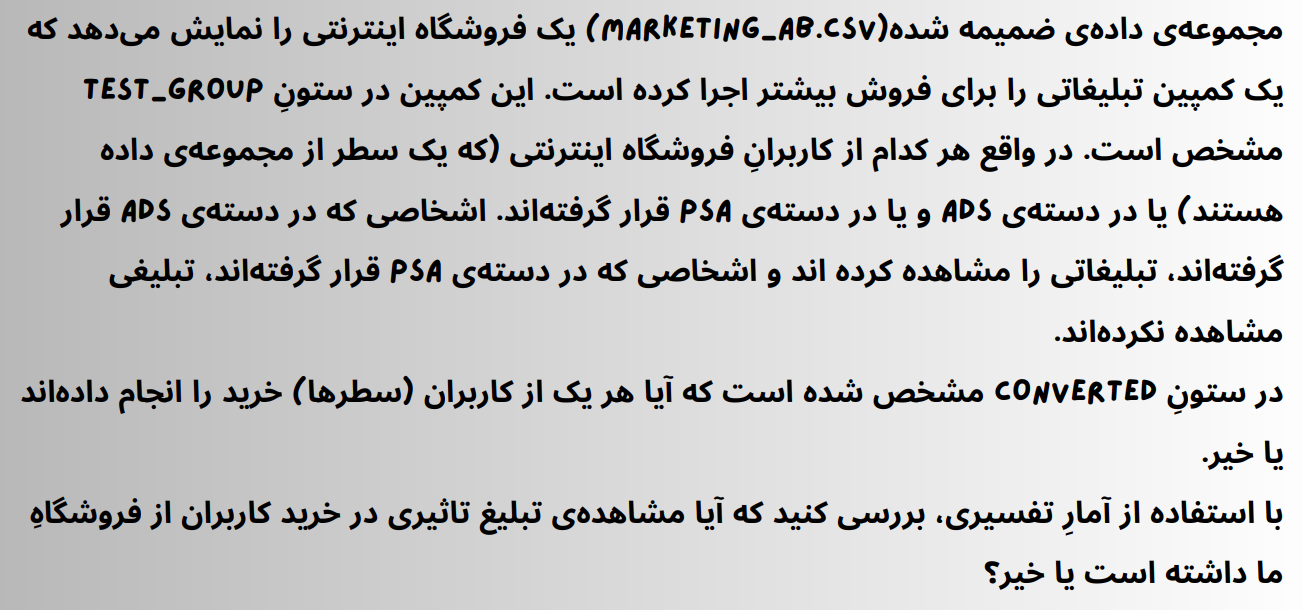

<div style="text-align: center; color: #6F2DA8">
    <h1 style="font-family: 'Calibri', sans-serif; text-align: center; font-size: 50px; margin-top: 0; margin-bottom: 20px; font-weight: bold;">
        Exercise 5 
    </h1> 
</div>

The attached dataset (Marketing_AB) displays an online store that has run an advertising campaign to boost sales. This campaign is indicated in Test_Group column. In fact, each of the online store users, which are rows in the dataset, are either in 'ADS' category or 'PSA' category. Those in 'ADS' category have seen an advertisement, and those in 'PSA' category have not. 'Coverted' column indicates whether each user (row) has made a purchase or not. Using descriptive statistics, examine whether seeing an advertisement has had any effect on our store's user purchases or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro

In [2]:
df = pd.read_csv('marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [3]:
print(f'Number of Rows    : {df.shape[0]}')
print(f'Number of Columns : {df.shape[1]}')
print(f'Features          : {df.columns.tolist()}')
print(f'Missing Values    : {df.isnull().values.sum()}')
print(f'Unique Values     : \n\n{df.nunique()}')

Number of Rows    : 588101
Number of Columns : 7
Features          : ['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads', 'most ads day', 'most ads hour']
Missing Values    : 0
Unique Values     : 

Unnamed: 0       588101
user id          588101
test group            2
converted             2
total ads           807
most ads day          7
most ads hour        24
dtype: int64


In [4]:
df['converted'].unique()               # Checking 'converted' column unique values.

array([False,  True])

In [5]:
df['test group'].unique()              # Checking 'test group' column unique values.

array(['ad', 'psa'], dtype=object)

In [6]:
sum(df['user id'].duplicated())        # Controling Duplicated data

0

# Chi_Square :

Since the data is not numerical, we can use a chi-square test to determine whether the variables are related or not :

In [7]:
CrossTab = pd.crosstab(df['test group'], df['converted'], margins=True)
CrossTab

converted,False,True,All
test group,,,
ad,550154,14423,564577
psa,23104,420,23524
All,573258,14843,588101


In [8]:
a = np.array([CrossTab.iloc[0][:2].values , CrossTab.iloc[1][:2].values])      # Main Part of CrossTab
a         

array([[550154,  14423],
       [ 23104,    420]], dtype=int64)

In [9]:
stats.chi2_contingency(a)

Chi2ContingencyResult(statistic=54.005823883685245, pvalue=1.9989623063390075e-13, dof=1, expected_freq=array([[550327.71899045,  14249.28100955],
       [ 22930.28100955,    593.71899045]]))

Due to the very low p-value, we can conclude that there is a significant difference between the two groups. Therefore, it can be said that the two variables are related.

# Determine the type of distribution :

In [10]:
df2 = df.replace({True: 1, False: 0 , 'ad': 0 , 'psa':1})
df2.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,0,0,130,Monday,20
1,1,1119715,0,0,93,Tuesday,22
2,2,1144181,0,0,21,Tuesday,18
3,3,1435133,0,0,355,Tuesday,10
4,4,1015700,0,0,276,Friday,14


In [11]:
shapiro(df2['converted'])

C:\Users\Farnaz\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.14109963178634644, pvalue=0.0)

In [12]:
shapiro(df2['test group'])

ShapiroResult(statistic=0.19345176219940186, pvalue=0.0)

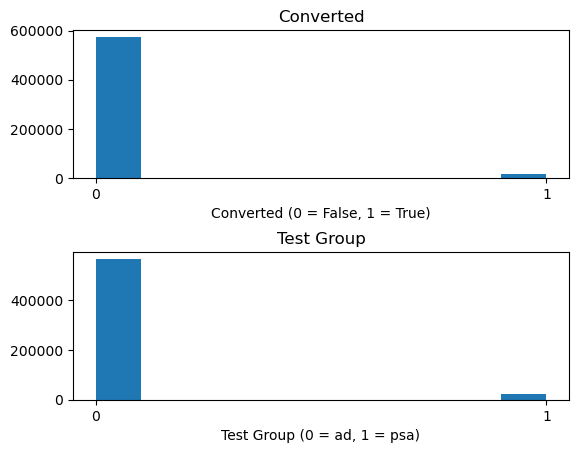

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=1)
axs[0].hist(df2['converted'])
axs[0].set_xticks([0, 1])
axs[0].set_xlabel('Converted (0 = False, 1 = True)')
axs[0].set_title('Converted')
axs[1].hist(df2['test group'])
axs[1].set_xticks([0, 1])
axs[1].set_xlabel('Test Group (0 = ad, 1 = psa)')
axs[1].set_title('Test Group')
fig.subplots_adjust(hspace=0.5)
plt.show()

The p-value in the Shapiro test is less than 5%, indicating that the data deviate from a normal distribution and this deviation is statistically significant. In other words, the data do not follow a normal distribution.Thus, we cannot use a t-test for this data because the t-test assumes that the data follow a normal distribution. We can use U-test instead.

# Solution 1 : U-Test

In [14]:
psa = df2[df2['test group'] == 1]       # People who didn't watch ads (Control Group)
A = psa['converted'].values
A.mean() * 100

1.785410644448223

About % 1.78 of the people who haven't watched the advertisement have made a purchase. 

In [15]:
ad = df2[df2['test group'] == 0]        # People who watched ads (Test Group)
B = ad['converted'].values
B.mean() * 100

2.5546559636683748

About % 2.55 of the people who have watched the advertisement have made a purchase. 

In [16]:
AB_diff = B.mean() - A.mean()
AB_diff * 100

0.7692453192201517

In [17]:
stats.mannwhitneyu(B, A, alternative='greater')

MannwhitneyuResult(statistic=6691636830.0, pvalue=8.526808965085939e-14)

People who watched the advertisement have made approximately 0.77% more purchases compared to those who did not watch the advertisement, and given the very small p-value in the U-test, this difference is statistically significant. This suggests that the advertisement had a significant impact, even though the effect size was very small.


# Solution 2 : CodeBase Solution

In [18]:
def AB_Test_Simulator ():
    N = int(input('Please Enter Number of Experiments :'))
    sample    = np.array([np.append(np.zeros(len(A)),np.ones(len(B))), np.append(A,B)]).T
    test_diff = np.empty([N, 1])
    for times in np.arange(N):
        test_lable = np.random.randint(0, 2, len(sample))
        test_data  = np.array ([test_lable , sample[:,1]]).T
        test_diff[times] = test_data[test_data[:,0] == 1][:,1].mean() - test_data[test_data[:,0] == 0][:,1].mean()
    P_Val = len(test_diff [test_diff >= AB_diff])/N *100
    print('P_Value is {} percent.'.format(P_Val))

In [ ]:
AB_Test_Simulator ()

Please Enter Number of Experiments :1000


In the simulation-based method, the p-value is zero, which confirms the conclusion from the U-test. This suggests that the difference in the average number of purchases between the two groups is statistically significant, indicating that the advertisement had a small but significant effect on purchases.

# Solution 3 : Binomial

In [ ]:
ad_converted = np.random.binomial(len(ad), df2.converted.mean(), 1000) / len(ad)
psa_converted = np.random.binomial(len(psa), df2.converted.mean(), 1000) / len(psa)

In [ ]:
p_diff = ad_converted - psa_converted

In [ ]:
p_diff.mean ()

In [ ]:
(p_diff > AB_diff).mean() * 100

The P-value is also zero in the simulation-based method using a binomial distribution, which confirms the results obtained from other methods.